## [Lecture 10.2: Bagging and Random Forest Classifier on MNIST](https://www.youtube.com/watch?v=fy7AhpixJ-A)

In this notebook, we will implement **multiclass MNIST digit recognition classifier** with **decision trees** and **ensemble techniques**.

**Import basic libraries**

In [1]:
# plotting utility
import matplotlib.pyplot as plt

# dataset loading through mnist
from keras.datasets import mnist

# training three classifiers: decision tree, bagging and random forest
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# model selection utilities for training and test split and cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# use shuffle-split cross validation for this exercise.
from sklearn.model_selection import ShuffleSplit

# make use of confusion matrix and classification report to evaluate performance
# on the test set.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# the model is defined through pipeline utility
from sklearn.pipeline import Pipeline

### Loading MNIST dataset
We begin by loading MNIST dataset with `load_data` function in `mnist` class
We obtain:
- Training feature matrix and labels
- Test feature matrix and labels

In [2]:
# Load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


As you know there are 60000 examples in training set and 10000 examples in the test set.

Each example is a grey scale image of size 28 x 28. There are 10 different labels - one for each digit 0 to 9.

In [3]:
print('Shape of training data', X_train.shape)
print('Shape of training labels', y_train.shape)
print('Shape of testing data', X_test.shape)
print('Shape of testing labels', y_test.shape)

Shape of training data (60000, 28, 28)
Shape of training labels (60000,)
Shape of testing data (10000, 28, 28)
Shape of testing labels (10000,)


Before using the dataset for training and evaluation, we need to flatten it into a vector. After flattening it, we have training and test examples represented with a vector of 784 features. Each feature records pixel intensity in each of 28 x 28 pixel.

We normalize the pixel intensity by dividing it with the maximum value i.e 255. In that sense we have feature value in the range 0 to 1.

In [4]:
# Flatten each input image into a vector of length 784
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing.
X_train = X_train/255
X_test = X_test/255

In [5]:
print('Shape of training data after flattening', X_train.shape)
print('Shape of testing data after flattening', X_test.shape)

Shape of training data after flattening (60000, 784)
Shape of testing data after flattening (10000, 784)


We use `ShuffleSplit` cross validation with 10 splits and 20% data set aside for model evaluation as a test data.

In [6]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

We define two functions:
1. `train_classifiers` contains a common code for training classifiers for MNIST multiclass classification problem.
    - It takes `estimator`, feature_matrix, labels, cross validation strategy and name of the classifier as input.
    - It first fits the estimator with feature matrix and labels.
    - It obtains cross validated `f1_macro` score for training set with 10-fold `ShuffleSplit` cross validation and prints it.

In [10]:
def train_classifiers(estimator, X_train, y_train, cv, name):
    estimator.fit(X_train, y_train)
    cv_train_score = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='f1_macro')
    print(f'On an average. {name} model has f1 score of '
          f'{cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on the training set')

2. The `eval` function takes estimator, test feature matrix and labels as input  and produce classification report and confusion matrix.
    - It first predicts labels for the test set.
    - Then it uses these predicted labels for calculating various evaluation metrics like precision, recall, f1 score and accuracy for each of the 10 classes.
    - It also obtains a confusion matrix by comparing these predictions with the actual labels and display it with `ConfusionMatrixDisplay` utility.

In [8]:
def eval(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)

    print('# Classification report')
    print(classification_report(y_test, y_pred))

    print('# Confusion matrix')
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

Let's train three classifiers with default parameters
- **Decision Tree**
- **Bagging classifier** - which uses tree as default classifier and trains multiple decision tree classifiers on different bags obtained through bootstrap sampling of training set.
- **Random forest classifier** - which is also a bagging technique, which trains different decision tree classifiers by randomly selecting attributes for splitting on bags of bootstrap sample of training set.

### **Decision trees for MNIST multiclass classification**
We instantiate a decision tree classifier with default parameters and train it. The `train_classifier` function prints mean of cross validated accuracy and standard deviation of the trained classifier on the training set.

In [11]:
decision_tree_pipeline = Pipeline([('classifier',DecisionTreeClassifier())])
train_classifiers(decision_tree_pipeline, X_train, y_train.ravel(), cv, 'decision tree')

On an average. decision tree model has f1 score of 0.867 +/- 0.004 on the training set


Let's evaluate the trained classifier on the test set

# Classification report
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       980
           1       0.96      0.96      0.96      1135
           2       0.87      0.86      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.88      0.87      0.87       982
           5       0.85      0.83      0.84       892
           6       0.89      0.89      0.89       958
           7       0.90      0.90      0.90      1028
           8       0.82      0.82      0.82       974
           9       0.86      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

# Confusion matrix


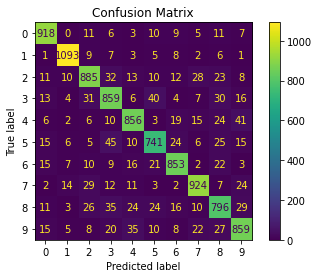

In [12]:
eval(decision_tree_pipeline, X_test, y_test)

### **MNIST classification with Bagging**
Lets instantiate a bagging classifier object with default parameters and train it

Observe the mean `f1_score` and its standard deviation obtained by the classifier based 10-fold cross validation of the training set

In [13]:
bagging_pipeline = Pipeline([('classifier', BaggingClassifier())])
train_classifiers(bagging_pipeline, X_train, y_train.ravel(), cv, "bagging")

On an average. bagging model has f1 score of 0.938 +/- 0.004 on the training set


Let's evaluate the trained classifier on the test set

# Classification report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.93      0.93      1032
           3       0.92      0.92      0.92      1010
           4       0.93      0.93      0.93       982
           5       0.92      0.90      0.91       892
           6       0.95      0.94      0.95       958
           7       0.96      0.94      0.95      1028
           8       0.92      0.90      0.91       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.94      0.94      0.94     10000

# Confusion matrix


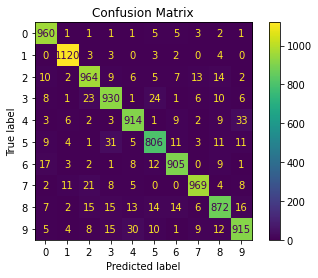

In [14]:
eval(bagging_pipeline, X_test, y_test)

### **Random Forest for MNIST multiclass classification**
Lets instantiate a random forest classifier object with default parameters and train it

Observe the mean f1_score and its standard deviation obtained by the classifier based 10-fold cross validation of the training set

In [15]:
random_forest_pipeline = Pipeline([('classifier', RandomForestClassifier())])
train_classifiers(random_forest_pipeline, X_train, y_train.ravel(), cv, "random forest")

On an average. random forest model has f1 score of 0.967 +/- 0.001 on the training set


Let's evaluate a random forest classifier on the test set and obtain classification report containing precision, recall, f1 score and accuracy for each class. It also calculates confusion matrix and displays it with `ConfusionMatrixDisplay` utility

# Classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.98      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

# Confusion matrix


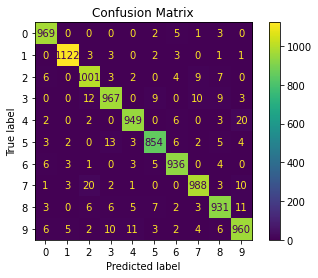

In [16]:
eval(random_forest_pipeline, X_test, y_test)

### Summary
- We trained three multi-class classifiers for handwritten digit recognition
- The decision-tree-classifier is a baseline-classifier, which obtained accuracy of 88% on the test set.
- Using bagging and training the same decision tree classifier gave us an increase of 6 percent point of accuracy, which translates to 94% accuracy on the test set.
- Finally random forest pushed that further to 97% 
- We can see that how ensemble techniques give better results on the classification task compared to a single classifier.
- With this demonstration, you have added three powerful tools in your ML toolkit


## [Lecture 10.3: Bagging and Random Forest Regressor on California Housing Dataset](https://www.youtube.com/watch?v=cjf5b1dx6Tk)
In this notebook, we will apply ensemble techniques problem in california housing dataset.

We have already applied different regressors on california housing dataset. In this notebook, we will make use of:
- Decision Tree regressor
- Bagging regressor
- Random Forest regressor

We will observe performance improvement when we use random forest over decision trees and bagging, which also uses decision tree regressors

In [25]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn.tree import DecisionTreeRegressor

In [26]:
np.random.seed(306)

Let's use `ShuffleSplit` as cv with 10 splits and 20% examples set aside as test examples

In [27]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

Let's download the data and split it into training and test

In [28]:
# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
labels *= 100
# train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

# train ------> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

### Training diffeent regressors
Let's train different regressors:

In [29]:
def train_regressor(estimator, X_train, y_train, cv, name):
    cv_results = cross_validate(estimator,
                                X_train,
                                y_train,
                                cv=cv,
                                scoring='neg_mean_absolute_error',
                                return_train_score=True,
                                return_estimator=True)
    
    cv_train_error = -1 * cv_results['train_score']
    cv_test_error = -1 * cv_results['test_score']

    print(f'On an average. {name} model makes and error of '
          f'{cv_train_error.mean():.3f}k +/- {cv_train_error.std():.3f}k on the training set')
    print(f'On an average. {name} model makes and error of '
          f'{cv_test_error.mean():.3f}k +/- {cv_test_error.std():.3f}k on the testing set')


In [24]:
#@title Decision Tree Regressor
train_regressor(DecisionTreeRegressor(),
                com_train_features,
                com_train_labels,
                cv,
                'decision tree regressor')

On an average. decision tree regressor model makes and error of 0.000k +/- 0.000k on the training set
On an average. decision tree regressor model makes and error of 47.419k +/- 1.114k on the testing set


In [30]:
#@title Bagging Regressor
train_regressor(BaggingRegressor(),
                com_train_features,
                com_train_labels,
                cv,
                'bagging regressor')

On an average. bagging regressor model makes and error of 14.446k +/- 0.190k on the training set
On an average. bagging regressor model makes and error of 35.355k +/- 1.044k on the testing set


#### Random Forest Regressor

In [31]:
#@title Random Forest Regressor
train_regressor(RandomForestRegressor(),
                com_train_features,
                com_train_labels,
                cv,
                'random forest regressor')

On an average. random forest regressor model makes and error of 12.626k +/- 0.069k on the training set
On an average. random forest regressor model makes and error of 33.203k +/- 0.702k on the testing set


### Parameter search for Random Forest Regressor

In [33]:
param_distributions = {
    'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500],
    'max_leaf_nodes': [2, 5, 10, 20, 50, 100]
}
search_cv = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=2), param_distributions=param_distributions,
    scoring='neg_mean_absolute_error', n_iter=10, random_state=0, n_jobs=2)

search_cv.fit(com_train_features, com_train_labels)

columns = [f'param_{name}' for name in param_distributions.keys()]
columns += ['mean_test_error', 'std_test_error']
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results['mean_test_error'] = -cv_results['mean_test_score']
cv_results['std_test_error'] = -cv_results['std_test_score']
cv_results[columns].sort_values(by='mean_test_error')

,param_n_estimators,param_max_leaf_nodes,mean_test_error,std_test_error
0,500,100,40.647217,-0.779740
2,10,100,41.061012,-0.974112
7,100,50,43.818901,-0.832671
8,1,100,47.757254,-1.573151
1,100,20,49.482152,-1.030793
6,50,20,49.597050,-0.999616
9,10,20,50.061604,-1.284793
3,500,10,55.017062,-1.077074
4,5,5,61.546459,-1.057208
5,5,2,73.409157,-1.316663


In [34]:
error = -search_cv.score(test_features, test_labels)
print(f'On average, our random forest regressor makes an error of {error:.2f} k$') 

On average, our random forest regressor makes an error of 40.47 k$


## [Lecture 10.5 AdaBoost and GradientBoost Classifier on MNIST ](https://www.youtube.com/watch?v=DhftGTaoFDI)

In this notebook, we will implement **multiclass MNIST digit recognition classifier** with **boosting**
- Adaboost
- GradientBoosting
- XGBoost

**Import Basic Libraries**

In [35]:
# plotting utility
import matplotlib.pyplot as plt

# dataset loading through mnist
from keras.datasets import mnist

# training three classifiers: AdaBoostClassifier,
# GradientBoostingClassifier and XGBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model selection utilities for training and test split and cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# use shuffle-split cross validation for this exercise.
from sklearn.model_selection import ShuffleSplit

# make use of confusion matrix and classification report to evaluate performance on the test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# the model is defined through pipeline utitlity
from sklearn.pipeline import Pipeline

### Loading MNIST dataset
We begin by loading MNIST dataset with `load_data` function in `mnist` class

We obtain:
- Training feature matrix and labels
- Test feature matrix and labels

In [36]:
# Load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

As you know there are 60000 examples in training set and 10000 examples in the test set.

Each example is a grey scale image of size 28 x 28. There are 10 different labels - one for each digit 0 to 9.

In [37]:
print('Shape of training data', X_train.shape)
print('Shape of training labels', y_train.shape)
print('Shape of testing data', X_test.shape)
print('Shape of testing labels', y_test.shape)

Shape of training data (60000, 28, 28)
Shape of training labels (60000,)
Shape of testing data (10000, 28, 28)
Shape of testing labels (10000,)


Before using the dataset for training and evaluation, we need to flatten it into a vector. After flattening it, we have training and test examples represented with a vector of 784 features. Each feature records pixel intensity in each of 28 x 28 pixel.

We normalize the pixel intensity by dividing it with the maximum value i.e 255. In that sense we have feature value in the range 0 to 1.

In [38]:
# Flatten each input image into a vector of length 784
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing.
X_train = X_train/255
X_test = X_test/255

We use ShuffleSplit cross validation with 10 splits and 20% data set aside for model evaluation as a test data.

In [39]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

We define two functions:
1. `train_classifiers` contains a common code for training classifiers for MNIST multiclass classification problem.
    - It takes `estimator`, feature_matrix, labels, cross validation strategy and name of the classifier as input.
    - It first fits the estimator with feature matrix and labels.
    - It obtains cross validated `f1_macro` score for training set with 10-fold `ShuffleSplit` cross validation and prints it.

In [40]:
def train_classifiers(estimator, X_train, y_train, cv, name):
    estimator.fit(X_train, y_train)
    cv_train_score = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='f1_macro')
    print(f'On an average. {name} model has f1 score of '
          f'{cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on the training set')

2. The `eval` function takes estimator, test feature matrix and labels as input  and produce classification report and confusion matrix.
    - It first predicts labels for the test set.
    - Then it uses these predicted labels for calculating various evaluation metrics like precision, recall, f1 score and accuracy for each of the 10 classes.
    - It also obtains a confusion matrix by comparing these predictions with the actual labels and display it with `ConfusionMatrixDisplay` utility.

In [41]:
def eval(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)

    print('# Classification report')
    print(classification_report(y_test, y_pred))

    print('# Confusion matrix')
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

Let's train two classifiers with default parameters
- **AdaBoostClassifier** that uses decision stumps as weak learners
- **GradientBoostingClassifier** that uses decision trees as weak learners

### **AdaBoost for MNIST multiclass classification**
We instantiate a AdaBoost classifier with default parameters and train it. The `train_classifier` function prints mean of cross validated accuracy and standard deviation of the trained classifier on the training set.

In [42]:
abc_pipeline = Pipeline([('classifier', AdaBoostClassifier())])
train_classifiers(abc_pipeline, X_train, y_train.ravel(), cv, 'AdaBoostClassifier')

On an average. AdaBoostClassifier model has f1 score of 0.712 +/- 0.016 on the training set


Let's evaluate the trained classifier on the test set.

# Classification report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       980
           1       0.85      0.94      0.90      1135
           2       0.79      0.58      0.67      1032
           3       0.68      0.67      0.68      1010
           4       0.72      0.72      0.72       982
           5       0.69      0.59      0.64       892
           6       0.72      0.86      0.78       958
           7       0.68      0.78      0.73      1028
           8       0.66      0.68      0.67       974
           9       0.62      0.55      0.58      1009

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.73     10000

# Confusion matrix


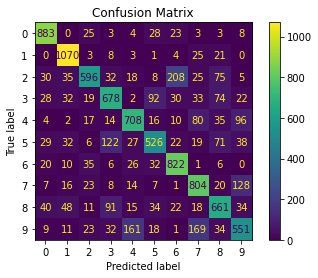

In [43]:
eval(abc_pipeline, X_test, y_test)

### **GradientBoostingClassifier for MNIST multiclass classification**
We instantiate a GradientBoosting classifier with default parameters and train it. The `train_classifier` function prints mean of cross validated accuracy and standard deviation of the trained classifier on the training set.

In [ ]:
# This model might take a lot of time to execute( > 45 mins), so run it at your own discretion
gbc_pipeline = Pipeline([('classifier', GradientBoostingClassifier())])
train_classifiers(gbc_pipeline, X_train, y_train.ravel(), cv, 'GradientBoostingClassifier')

Let's evaluate the trained classifier on the test set.

In [ ]:
eval(gbc_pipeline, X_test, y_test)

### MNIST classification with XGBoost classifier

In [46]:
from xgboost import XGBClassifier

In [47]:
?XGBClassifier

In [ ]:
# This model might take a lot of time to execute( > 60 mins), so run it at your own discretion
xbc_pipeline = Pipeline([('classifier', XGBClassifier())])
train_classifiers(xbc_pipeline, X_train, y_train.ravel(), cv, 'XGBoostClassifier')

In [ ]:
eval(xbc_pipeline, X_test, y_test)

## [Lecture 10.6 AdaBoost and GradientBoost Regressor on California Housing](https://www.youtube.com/watch?v=yJjCDkjNNaM)

In this notebook, we will apply ensemble techniques regression problem in california housing dataset.

We already have applied different regressors on california housing dataset. In this notebook, we will make use of 
- AdaBoost Regressor
- Gradient Boosting Regressor
- XGBoost Regressor

In [50]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

In [51]:
np.random.seed(306)

Let's use `ShuffleSplit` as cv with 10 splits and 20% examples set aside as test examples

In [52]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

Let's download the data and split it into training and test

In [53]:
# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
labels *= 100
# train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

# train ------> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

In [54]:
def train_regressor(estimator, X_train, y_train, cv, name):
    cv_results = cross_validate(estimator,
                                X_train,
                                y_train,
                                cv=cv,
                                scoring='neg_mean_absolute_error',
                                return_train_score=True,
                                return_estimator=True)
    
    cv_train_error = -1 * cv_results['train_score']
    cv_test_error = -1 * cv_results['test_score']

    print(f'On an average. {name} model makes and error of '
          f'{cv_train_error.mean():.3f}k +/- {cv_train_error.std():.3f}k on the training set')
    print(f'On an average. {name} model makes and error of '
          f'{cv_test_error.mean():.3f}k +/- {cv_test_error.std():.3f}k on the testing set')

In [55]:
#@title AdaBoostRegressor
train_regressor(AdaBoostRegressor(),
                com_train_features,
                com_train_labels,
                cv,
                'AdaBoostRegressor')

On an average. AdaBoostRegressor model makes and error of 73.263k +/- 6.031k on the training set
On an average. AdaBoostRegressor model makes and error of 73.623k +/- 6.057k on the testing set


In [56]:
#@title GradientBoostingRegressor
train_regressor(GradientBoostingRegressor(),
                com_train_features,
                com_train_labels,
                cv,
                'GradientBoostingRegressor')

On an average. GradientBoostingRegressor model makes and error of 35.394k +/- 0.273k on the training set
On an average. GradientBoostingRegressor model makes and error of 36.773k +/- 0.723k on the testing set


In [57]:
?GradientBoostingRegressor

### XGBoost

In [58]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Extreme gradient boosting (XGBoost) is the latest boosting technique. It is more regularized form of gradient boosting. With regularization, it is able to achieve better generalized performance than gradient boosting

In [59]:
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(objective='reg:squarederror')

In [60]:
?XGBRegressor

In [62]:
train_regressor(xgb_regressor,
                com_train_features,
                com_train_labels,
                cv,
                'XGBRegressor')

On an average. XGBRegressor model makes and error of 35.441k +/- 0.228k on the training set
On an average. XGBRegressor model makes and error of 36.815k +/- 0.707k on the testing set
